# Packs

In [ ]:
import os
import random
import shutil
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import StratifiedShuffleSplit , StratifiedKFold
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd
import scipy.io as sio
from tqdm.notebook import tqdm

import json


In [ ]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  root_dir = '/content/drive/'
  drive_prefix = 'MyDrive/'
  drive.mount(root_dir)
else:
  root_dir = '/home/ehudmal/ML_Course_works/assignment_4'
  drive_prefix = ''

project_dir = os.path.join(root_dir, f'{drive_prefix}Flowers_datasets_ML_EX_4')
pictures_dir = os.path.join(project_dir, '102_flowers_jpg')
labels_path = os.path.join(project_dir, 'imagelabels.mat')
splits = os.path.join(project_dir, 'setid.mat')
split = False


In [ ]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    res = f"""
    Total model parameters: {total_params}
    Total trainable parameters: {trainable_params}
    Total non-trainable parameters: {non_trainable_params}
    """
    print(res)
    return total_params, trainable_params, non_trainable_params

# Data preperation

In [ ]:
labels_vector = sio.loadmat(labels_path)
len(np.unique(labels_vector['labels'][0])), np.count_nonzero(labels_vector['labels'][0]), (labels_vector['labels'][0] == 0).sum()

(102, 8189, np.int64(0))

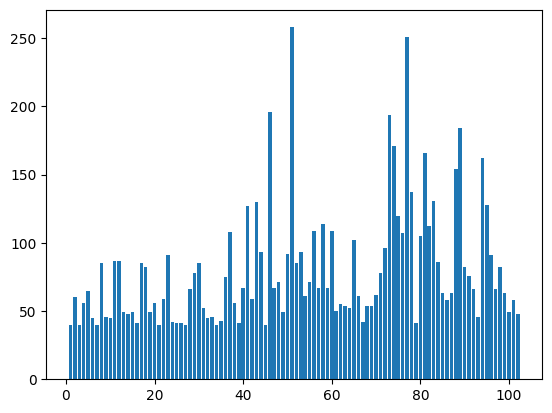

In [ ]:
classes, n_for_class = np.unique(labels_vector['labels'][0], return_counts=True)
plt.bar(classes, n_for_class)
plt.show()

Checking files length

In [ ]:
files_in_dir = os.listdir(pictures_dir)
file_name_lengths = [len(file_name) for file_name in files_in_dir]
if len(set(file_name_lengths)) == 1:
    print(f"All file names have the same length: {file_name_lengths[0]}")
else:
    print("File names have different lengths.")
    print(f"Unique lengths found: {set(file_name_lengths)}")

File names have different lengths.
Unique lengths found: {9, 7}


Validating files names

In [ ]:
all([f'image_{str(i+1).zfill(5)}.jpg' in files_in_dir for i in range(len(labels_vector['labels'][0]))])

False

Mapping picture to label

In [ ]:
pic2label = {}
for i in range(len(labels_vector['labels'][0])):
  filename = f'image_{str(i+1).zfill(5)}.jpg'
  pic2label[filename] = labels_vector['labels'][0][i]
len(pic2label)

8189

Splitting data to dirs

In [ ]:

dataset_dir = os.path.join(pictures_dir,'dataset')
if split:
  print("SPLITING!!")
  os.makedirs(dataset_dir, exist_ok=True)


  # Create directories for each class
  for label in set(pic2label.values()):
    class_dir = os.path.join(dataset_dir, f'class_{label}')
    os.makedirs(class_dir, exist_ok=True)

  # Move files into the appropriate class folders
  for filename, label in pic2label.items():
    src_path = os.path.join(pictures_dir, filename)
    dst_path = os.path.join(dataset_dir, f'class_{label}', filename)
    shutil.move(src_path, dst_path)


Cross valdiation splitting

In [ ]:
original_dataset = ImageFolder(root=dataset_dir, transform=None)
labels = original_dataset.targets
class_names = original_dataset.classes

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Train and Val+Test
train_idx, val_test_idx = next(sss.split(np.zeros(len(labels)), labels))
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Val and Test
val_idx, test_idx = next(sss.split(np.zeros(len(val_test_idx)), np.array(labels)[val_test_idx]))

train_dataset = Subset(original_dataset, train_idx)
val_dataset = Subset(original_dataset, [val_test_idx[i] for i in val_idx])
test_dataset = Subset(original_dataset, [val_test_idx[i] for i in test_idx])

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(4094, 2047, 2048)

In [ ]:
from PIL import Image
def custom_collate(batch, trasnform):
    images, labels = [], []
    for img, label in batch:
        if isinstance(img, Image.Image):
            img = trasnform(img)
        images.append(img)
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)



# Model Training

In [ ]:
num_classes = len(classes)
num_classes

102

## Training functions

In [ ]:

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f'Random seed set as {seed}')

def get_device():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'Computation device: {device}')
    return device

def calculate_loss_and_accuracy(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

def train_model(model, criterion, optimizer, train_loader, eval_loader, test_loader, num_epochs=25, patience = 7):
    device = get_device()
    model.to(device)
    train_losses, eval_losses, test_losses = [], [], []
    train_accuracies, eval_accuracies, test_accuracies = [], [], []
    patience_counter = 0
    best_eval_loss = float('inf')
    patience = patience

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation phase
        eval_loss, eval_accuracy = calculate_loss_and_accuracy(model, eval_loader, criterion, device)
        eval_losses.append(eval_loss)
        eval_accuracies.append(eval_accuracy)

        print(f"Eval Loss: {eval_loss:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            patience_counter = 0
            best_model_weights = model.state_dict().copy()  # Save the best model weights
        else:
            patience_counter += 1
            print(f"Early stopping patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    test_loss, test_accuracy = calculate_loss_and_accuracy(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return train_losses, eval_losses, test_losses, train_accuracies, eval_accuracies, test_accuracies

def save_results(res, model_name, lr, batch_size):
    base_dir = os.path.join('./results', model_name)
    batch_size_dir = os.path.join(base_dir, f'{batch_size}_batch_size')
    save_dir = os.path.join(batch_size_dir, f'{lr}_lr')
    os.makedirs(save_dir, exist_ok=True)

    train_losses, eval_losses, test_losses, train_accuracies, eval_accuracies, test_accuracies = res
    plot_lists(train_losses, eval_losses,  'Loss', save_dir)
    plot_lists(train_accuracies, eval_accuracies, 'Accuracy', save_dir)

    res_dict = {
                'train_losses':train_losses,
                'eval_losses':eval_losses,
                'test_losses':test_losses,
                'train_accuracies':train_accuracies,
                'eval_accuracies':eval_accuracies,
                'test_accuracies':test_accuracies
               }
    test_results = {
                    'test_losses':test_losses,
                    'test_accuracies':test_accuracies
                   }

    with open(os.path.join(save_dir, 'res_dict.json'), 'w') as f:
        json.dump(res_dict, f)

    with open(os.path.join(save_dir, 'test_res_dict.json'), 'w') as f:
        json.dump(test_results, f)

def plot_lists(train_values, eval_values, measurement, save_dir):

    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(train_values) + 1), train_values, label='Train')
    plt.plot(range(1, len(eval_values) + 1), eval_values, label='Eval')
    plt.xlabel('Epochs')
    plt.ylabel(measurement)
    plt.legend()
    plt.title(f"{model_name} - {measurement}")

    save_path = os.path.join(save_dir, f"{measurement}.pdf")
    plt.savefig(save_path)
    plt.close()

    print(f"Figure saved at: {save_path}")

In [ ]:
def get_vgg19_dataloaders(train_dataset, val_dataset, test_dataset, batch_size = 16):
    vgg19_train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    vgg19_eval_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    vgg19_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: custom_collate(x, vgg19_train_transform))
    vgg19_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: custom_collate(x, vgg19_eval_test_transform))
    vgg19_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: custom_collate(x, vgg19_eval_test_transform))
    return vgg19_train_loader, vgg19_val_loader, vgg19_test_loader



def run_vgg19_experiment(train_dataset, val_dataset, test_dataset, lr, batch_size):
    vgg19 = models.vgg19(pretrained=True)
    for param in vgg19.parameters():
        param.requires_grad = False

    vgg19.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
    vgg19_train_loader, vgg19_val_loader, vgg19_test_loader = get_vgg19_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)

    res = train_model(vgg19, nn.CrossEntropyLoss(), torch.optim.Adam(vgg19.parameters(), lr=lr), vgg19_train_loader, vgg19_val_loader, vgg19_test_loader, num_epochs=100)
    return res



In [ ]:
def get_yolo_dataloaders(train_dataset, val_dataset, test_dataset, batch_size = 16):
    yolo_train_transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    yolo_eval_test_transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    yolo_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: custom_collate(x, yolo_train_transform))
    yolo_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: custom_collate(x, yolo_eval_test_transform))
    yolo_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: custom_collate(x, yolo_eval_test_transform))
    return yolo_train_loader, yolo_val_loader, yolo_test_loader

def run_yolo_experiment(train_dataset, val_dataset, test_dataset, lr, batch_size):
    yolo5 = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    yolo_backbone = yolo5.model.model.model[:10]
    for param in yolo_backbone.parameters():
        param.requires_grad = False

    dummy_input = torch.randn(1, 3, 640, 640).to('cuda')
    features = yolo_backbone(dummy_input)
    print(features.shape)

    feature_dim = features.shape[1] * features.shape[2] * features.shape[3]

    yolo_classifier = nn.Sequential(
        yolo_backbone,
        nn.Flatten(),
        nn.Linear(in_features=feature_dim, out_features=1024),
        nn.Linear(in_features=1024, out_features=num_classes)
    ).to('cuda')

    yolo_train_loader, yolo_val_loader, yolo_test_loader = get_yolo_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)

    res = train_model(yolo_classifier, nn.CrossEntropyLoss(), torch.optim.Adam(yolo_classifier.parameters(), lr=lr), yolo_train_loader, yolo_val_loader, yolo_test_loader, num_epochs=100)
    return res



In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models import resnet18, ResNet18_Weights

def get_resnet_dataloaders(train_dataset, val_dataset, test_dataset, batch_size):
    resnet_train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    resnet_eval_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    resnet_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: custom_collate(x, resnet_train_transform))
    resnet_val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: custom_collate(x, resnet_eval_test_transform))
    resnet_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: custom_collate(x, resnet_eval_test_transform))
    return resnet_train_loader, resnet_val_loader, resnet_test_loader


def run_resnet_experiment(train_dataset, val_dataset, test_dataset, model_name, lr, batch_size):
    if model_name == 'resnet18':
        resnet_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    elif model_name == 'resnet50':
        resnet_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    elif model_name == 'resnet101':
        resnet_model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
    else:
        raise Exception("Un supported ResnetModel")

    resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)


    for param in resnet_model.parameters():
        param.requires_grad = False

    for param in resnet_model.fc.parameters():
        param.requires_grad = True

    resnet_train_loader, resnet_val_loader, resnet_test_loader = get_resnet_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=batch_size)
    res = train_model(resnet_model, nn.CrossEntropyLoss(), torch.optim.Adam(resnet_model.parameters(), lr=lr), resnet_train_loader, resnet_val_loader, resnet_test_loader, num_epochs=100)
    return res





In [ ]:
import itertools


lrs = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32]
models_to_test = ['vgg19', 'yolov5', 'resnet18']

for model_name, lr, batch_size in itertools.product(models_to_test, lrs, batch_sizes):
    if model_name == 'vgg19':
        res = run_vgg19_experiment(train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, lr=lr, batch_size=batch_size)
    elif model_name == 'yolov5':
        res = run_yolo_experiment(train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, lr=lr, batch_size=batch_size)
    elif 'resnet' in model_name:
        res = run_resnet_experiment(train_dataset=train_dataset, val_dataset=val_dataset, test_dataset=test_dataset, model_name=model_name, lr=lr, batch_size=batch_size)
    save_results(res=res, model_name=model_name, lr=lr, batch_size=batch_size)